# Module 3 - Algorithm auditing: Accuracy, Fairness and Interpretability 


### Assignment overview

In this assignment, you will be asked to evaluate a set of trained classifiers for accuracy, fairness and transparency. The classifiers have been trained on the [NIJ Recidivism Challenge Dataset](https://nij.ojp.gov/funding/recidivism-forecasting-challenge) to predict whether or not an individual will be arrested for a new crime within 3 years after being released on parole. 

The assignment is modeled after “Accuracy, Fairness, and Interpretability of Machine Learning Criminal Recidivism Models, by Eric Ingram, Furkan Gursoy, Ioannis A. Kakadiaris (https://arxiv.org/abs/2209.14237). 

For this assignment, it is possible to work in **groups of up to 2 students**. 

### Group members
Leave blanks if group has less than 2 members:
- Student 1:
- Student 2:


### Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:
1. Describe different fairness metrics, such as statistical parity, equal opportunity and equal accuracy 
2. Discuss fairness and fairness metrics from the perspective of multiple stakeholders 
3. Define objective functions based on fairness metrics  
4. Evaluate a model’s transparency using strategies such as global surrogate models, permutation feature importance, and Shapley Additive Explanations (SHAP) 
5. Evaluate common machine learning models based on their accuracy, fairness and interpretability 
6. Describe how metrics such as accuracy and fairness need to be balanced for a trained model to have acceptable accuracy and low bias 

In [1]:
# pip install aif360[AdversarialDebiasing]

In [2]:
# pip install eli5

In [3]:
# pip install aif360[Reductions]

In [4]:
# pip install aif360[inFairness]


## Import Libraries:

In [5]:
# May require installation of additional libraries like aif360 and eli5

import pandas as pd
import numpy as np
import joblib

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
)

import matplotlib.pyplot as plt
import eli5
from sklearn.inspection import permutation_importance

c:\Users\athen\anaconda3\envs\dsci430\lib\site-packages\inFairness\utils\ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
c:\Users\athen\anaconda3\envs\dsci430\lib\site-packages\inFairness\utils\ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg =

# Part 1: Getting started:

Before starting this assignment, we ask you to read the paper it has been modeled after, to get an idea of the problem we are working on: https://arxiv.org/abs/2209.14237

You can also review the original dataset source [here](https://nij.ojp.gov/funding/recidivism-forecasting-challenge). The website includes a lot of information on the dataset and a detailed description of each of its columns (look for Appendix 2: Codebook).

Now that you have familiarized with the problem, you know that the goal is predicting the binary variable `Recidivism_Within_3years`, which indicates whether or not the person has committed a new felony or misdemeanour within 3 years from the beginning of parole supervision. 

The National Institute of Justice’s (NIJ) obviously would want to deploy a highly accurate predictive model, to make sure that only deserving people get released on parole. Unfortunately, the existence of bias in the training set (typically historical or representation bias) makes it very likely to end up with an unfair classifier, that is, a classifier that produces different results for different protected classes of population.

Your job is to evaluate 4 classifiers, pre-trained and provided to you. This is called **algorithm auditing:** you are not the designer of the model, but you are in charge of evaluating its performance. Algorithm auditing can focus on various metrics and populations of interest, but in this case we will focus on evaluating **accuracy, fairness and transparency** of each algorithm.

To begin, load the dataset and classifiers by running the cells below:

In [8]:
train_df = pd.read_csv("data/training_set.csv")
test_df = pd.read_csv("data/testing_set.csv")

In [9]:
test_df.head()

,Unnamed: 0,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,...,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3,Training_Sample
0,3735,3848,M,BLACK,48 or older,1,No,6.0,Standard,High School Diploma,...,0.0,0.0,1.00000,0.299385,No,No,No,No,No,0
1,5039,5174,M,BLACK,48 or older,20,No,2.0,Specialized,High School Diploma,...,0.0,0.0,1.00000,1.544397,No,Yes,No,No,Yes,1
2,16027,16485,F,WHITE,33-37,10,NaN,6.0,High,High School Diploma,...,0.0,0.0,0.51049,1.277098,No,No,No,No,No,1
3,18863,19486,F,WHITE,43-47,11,NaN,5.0,Standard,High School Diploma,...,0.0,0.0,1.00000,1.006198,No,No,No,No,No,1
4,14013,14408,M,WHITE,33-37,14,No,4.0,Standard,High School Diploma,...,0.0,0.0,1.00000,1.318592,No,No,No,No,No,1


In [10]:
# Separating features and target
X_train, y_train = (
    train_df.drop(columns=["Recidivism_Within_3years"]),
    train_df["Recidivism_Within_3years"],
)
X_test, y_test = (
    test_df.drop(columns=["Recidivism_Within_3years"]),
    test_df["Recidivism_Within_3years"],
)

In [14]:
# Loading classifiers
logreg_model  = joblib.load("models_for_A3/NIJ_logreg.joblib")
rf_model      = joblib.load("models_for_A3/NIJ_rf.joblib")
tree_model    = joblib.load("models_for_A3/NIJ_tree.joblib")
xgboost_model = joblib.load("models_for_A3/NIJ_xgboost.joblib")

c:\Users\athen\anaconda3\envs\dsci430\lib\pickle.py:1718: UserWarning: [21:25:19] WARNING: D:\bld\xgboost-split_1765326876395\work\src\gbm\../common/error_msg.h:83: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


# Part 2: Classifiers' Accuracy (and other performance metrics):

First, we will evaluate each classifier's accuracy, together with other performance metrics that help us understanding how reliable the classifier's answers are. In addition to accuracy, we will use, **precision, recall and F1 score.**

### Question 1

Can you provide definition and formula for accuracy, precision, recall and F1 score, as a function of True Positives (TP), True Negatives (TN), False Positives (FP) and False Negatives (FN)?

It may help you use this table for reference:

<img src="ConfMatrix.png" alt="drawing" width="500"/>

Here, we are giving you the definition of AUC, as a reminder and example (note that the other metrics will need the formula):

**AUC:** AUC stands for Area Under the ROC curve. The ROC (receiver operating characteristic) curve is a plot of the recall and false positive rate of a classifier for different classification thresholds (see [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) for more details). AUC values go between 0 and 1. Higher values are more desirable as they indicate that the classifier is good at avoiding both false positives and false negatives. A value of 0.5 for a binary classification indicates that the classifier is no better at predicting the outcome than random guessing.

**Add remaining definitions and formulas here**

| Metric | Formula |
| ------ | ------- |
| Accuracy | (TP + TN) / (TP + TN + FP + FN) | 
| Precision | TP / (TP + FP) | 
| Recall | TP / (TP + FN) |
| F1 Score | 2 × (Precision × Recall) / (Precision + Recall) |


### Question 2

For every classifier given, calculate and report accuracy, precision, recall and F1 score on the test set. For ease of visualization and comparison, we will summarize these results in this dictionary:

In [15]:
results_dict = {}

There are different options available to us to compute fairness metrics, such as the many functions included in sklearn. For this exercise, however, we will focus on working with the [aif360](https://aif360.readthedocs.io/en/stable/Getting%20Started.html) library, an open source library designed specifically to examine and mitigate discrimination and bias in machine learning models.

Let's see in an example how we can use aif360 to compute standard performance metrics. We will start with the Random Forest model.

In [16]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# When using aif360, the target has to be numerical, so we will start by converting our target column. Since we are 
# only interested in the metrics from the test set, we will convert only the test target

# Define your mapping
label_map = {"No": 0, "Yes": 1}

# Convert y_test
y_test_num = y_test.map(label_map)

# Since aif360 focuses on fairness, it needs us to identify the protected attribute we will use to segment the population.
protected_attr = 'pipeline-2__Race_WHITE'   

# aif360 can not handle Nans - we must impute before converting. For this purpose, I can use the transformer included in 
# the RF model
X_test_array = rf_model.named_steps['ct'].transform(X_test)

feature_names = rf_model.named_steps['ct'].get_feature_names_out()

X_test_transformed = pd.DataFrame(X_test_array, columns=feature_names, index=X_test.index)

# Locate protected attribute column in transformed test set.
protected_idx = X_test_transformed.columns.get_loc(protected_attr)

# Now that we have collected all this information, we can create a BinaryLabelDataset,
# aif360 base class for all structured datasets with binary labels - like ours!
# https://aif360.readthedocs.io/en/stable/modules/generated/aif360.datasets.BinaryLabelDataset.html#aif360.datasets.BinaryLabelDataset

aif_test = BinaryLabelDataset(
    favorable_label=1, # Being identified as not having committed a crime is the favorable outcome
    unfavorable_label=0,
    df=pd.concat([X_test_transformed, y_test_num], axis=1),
    label_names=[y_test.name],
    protected_attribute_names=[protected_attr]
)


In [17]:
# Now, we need to do a similar process and create a BinaryLabelDataset for the predictions of the Random Forest model

# First, we'll get the predictions and convert them to 0 and 1
y_pred = rf_model.predict(X_test)
y_pred_num = pd.Series(y_pred, index=y_test.index).map(label_map)

# Then, we will create a copy of the transformed test feature matrix and attach the predictions to it
pred_df = X_test_transformed.copy()
pred_df[y_test.name] = y_pred_num

# Finally, we piece everything together in a BinaryLabelDataset 
aif_pred = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=pred_df,
    label_names=[y_test.name],
    protected_attribute_names=[protected_attr]
)

In [18]:
# We are now ready to compute some metrics using aif_test (our ground truth) and aif_pred (our predictions)
classified_metric_rf = ClassificationMetric(
    aif_test,
    aif_pred,
    unprivileged_groups=[{protected_attr: 0}],
    privileged_groups=[{protected_attr: 1}]
)

precision = classified_metric_rf.precision()
recall = classified_metric_rf.recall()

# aif360 does not have a function foro F1 - we will compute F1 manually
if (precision + recall) > 0:
    f1 = 2 * (precision * recall) / (precision + recall)
else:
    f1 = 0.0

# Saving results in the dictionary
results_dict["RandomForest"] = {
    "accuracy": format(classified_metric_rf.accuracy(), ".3f"),
    "precision": format(precision, ".3f"),
    "recall": format(recall, ".3f"),
    "f1_score": format(f1, ".3f"),
}


In [19]:
# We can check our results
pd.DataFrame(results_dict)

,RandomForest
accuracy,0.720
precision,0.740
recall,0.788
f1_score,0.763


Repeat the steps above for the logistic regression, decision tree, and xgboost model, and add the results to the dictionary.

In [26]:
# Check the structure of each model
print("Logistic Regression steps:")
print(logreg_model.named_steps.keys())
print()

print("Random Forest steps:")
print(rf_model.named_steps.keys())
print()

print("Decision Tree steps:")
print(tree_model.named_steps.keys())
print()

print("XGBoost steps:")
print(xgboost_model.named_steps.keys())

Logistic Regression steps:
dict_keys(['columntransformer', 'logisticregression'])

Random Forest steps:
dict_keys(['ct', 'rf'])

Decision Tree steps:
dict_keys(['ct', 'dt'])

XGBoost steps:
dict_keys(['ct', 'XGB'])


### LogReg Model:

In [27]:
# Transform test data using LogReg model
X_test_array_lr = logreg_model.named_steps['columntransformer'].transform(X_test)
feature_names_lr = logreg_model.named_steps['columntransformer'].get_feature_names_out()
X_test_transformed_lr = pd.DataFrame(X_test_array_lr, columns=feature_names_lr, index=X_test.index)

# Create ground truth dataset (reuse protected_attr, same for all)
aif_test_lr = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=pd.concat([X_test_transformed_lr, y_test_num], axis=1),
    label_names=[y_test.name],
    protected_attribute_names=[protected_attr]
)

# Get predictions
y_pred_lr = logreg_model.predict(X_test)
y_pred_num_lr = pd.Series(y_pred_lr, index=y_test.index).map(label_map)

# Create predictions dataset
pred_df_lr = X_test_transformed_lr.copy()
pred_df_lr[y_test.name] = y_pred_num_lr

aif_pred_lr = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=pred_df_lr,
    label_names=[y_test.name],
    protected_attribute_names=[protected_attr]
)

# Calculate metrics
classified_metric_lr = ClassificationMetric(
    aif_test_lr,
    aif_pred_lr,
    unprivileged_groups=[{protected_attr: 0}],
    privileged_groups=[{protected_attr: 1}]
)

precision_lr = classified_metric_lr.precision()
recall_lr = classified_metric_lr.recall()

if (precision_lr + recall_lr) > 0:
    f1_lr = 2 * (precision_lr * recall_lr) / (precision_lr + recall_lr)
else:
    f1_lr = 0.0

# Store results
results_dict["LogisticRegression"] = {
    "accuracy": format(classified_metric_lr.accuracy(), ".3f"),
    "precision": format(precision_lr, ".3f"),
    "recall": format(recall_lr, ".3f"),
    "f1_score": format(f1_lr, ".3f"),
}

### Decision Tree Model:

In [29]:
# Transform test data using Decision Tree model
X_test_array_dt = tree_model.named_steps['ct'].transform(X_test)
feature_names_dt = tree_model.named_steps['ct'].get_feature_names_out()
X_test_transformed_dt = pd.DataFrame(X_test_array_dt, columns=feature_names_dt, index=X_test.index)

# Create ground truth dataset
aif_test_dt = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=pd.concat([X_test_transformed_dt, y_test_num], axis=1),
    label_names=[y_test.name],
    protected_attribute_names=[protected_attr]
)

# Get predictions
y_pred_dt = tree_model.predict(X_test)
y_pred_num_dt = pd.Series(y_pred_dt, index=y_test.index).map(label_map)

# Create predictions dataset
pred_df_dt = X_test_transformed_dt.copy()
pred_df_dt[y_test.name] = y_pred_num_dt

aif_pred_dt = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=pred_df_dt,
    label_names=[y_test.name],
    protected_attribute_names=[protected_attr]
)

# Calculate metrics
classified_metric_dt = ClassificationMetric(
    aif_test_dt,
    aif_pred_dt,
    unprivileged_groups=[{protected_attr: 0}],
    privileged_groups=[{protected_attr: 1}]
)

precision_dt = classified_metric_dt.precision()
recall_dt = classified_metric_dt.recall()

if (precision_dt + recall_dt) > 0:
    f1_dt = 2 * (precision_dt * recall_dt) / (precision_dt + recall_dt)
else:
    f1_dt = 0.0

# Store results
results_dict["DecisionTree"] = {
    "accuracy": format(classified_metric_dt.accuracy(), ".3f"),
    "precision": format(precision_dt, ".3f"),
    "recall": format(recall_dt, ".3f"),
    "f1_score": format(f1_dt, ".3f"),
}

### XGBoost Model:

In [36]:
# Transform test data using XGBoost model
X_test_array_xgb = xgboost_model.named_steps['ct'].transform(X_test)
feature_names_xgb = xgboost_model.named_steps['ct'].get_feature_names_out()
X_test_transformed_xgb = pd.DataFrame(X_test_array_xgb, columns=feature_names_xgb, index=X_test.index)

# Create ground truth dataset
aif_test_xgb = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=pd.concat([X_test_transformed_xgb, y_test_num], axis=1),
    label_names=[y_test.name],
    protected_attribute_names=[protected_attr]
)

# Get predictions
y_pred_xgb_raw = xgboost_model.predict(X_test)

# Check if predictions are already numeric or strings
if isinstance(y_pred_xgb_raw[0], (int, np.integer, float, np.floating)):
    # Already numeric - convert to int just to be safe
    y_pred_num_xgb = pd.Series(y_pred_xgb_raw.astype(int), index=y_test.index)
else:
    # String predictions - map them
    y_pred_num_xgb = pd.Series(y_pred_xgb_raw, index=y_test.index).map(label_map)

print(f"XGBoost prediction check:")
print(f"Unique values: {y_pred_num_xgb.unique()}")
print(f"Value counts:\n{y_pred_num_xgb.value_counts()}")

# Create predictions dataset
pred_df_xgb = X_test_transformed_xgb.copy()
pred_df_xgb[y_test.name] = y_pred_num_xgb

# Handle NAs if present
if pred_df_xgb.isna().any().any():
    pred_df_xgb = pred_df_xgb.fillna(0)

aif_pred_xgb = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=pred_df_xgb,
    label_names=[y_test.name],
    protected_attribute_names=[protected_attr]
)

# Calculate metrics
classified_metric_xgb = ClassificationMetric(
    aif_test_xgb,
    aif_pred_xgb,
    unprivileged_groups=[{protected_attr: 0}],
    privileged_groups=[{protected_attr: 1}]
)

precision_xgb = classified_metric_xgb.precision()
recall_xgb = classified_metric_xgb.recall()

if (precision_xgb + recall_xgb) > 0:
    f1_xgb = 2 * (precision_xgb * recall_xgb) / (precision_xgb + recall_xgb)
else:
    f1_xgb = 0.0

# Store results
results_dict["XGBoost"] = {
    "accuracy": format(classified_metric_xgb.accuracy(), ".3f"),
    "precision": format(precision_xgb, ".3f"),
    "recall": format(recall_xgb, ".3f"),
    "f1_score": format(f1_xgb, ".3f"),
}

print("\nXGBoost Results:")
print(results_dict["XGBoost"])

XGBoost prediction check:
Unique values: [0 1]
Value counts:
1    4965
0    2786
Name: count, dtype: int64

XGBoost Results:
{'accuracy': '0.741', 'precision': '0.745', 'recall': '0.833', 'f1_score': '0.787'}


In [37]:
# We can check our results
pd.DataFrame(results_dict)

,RandomForest,LogisticRegression,DecisionTree,XGBoost
accuracy,0.720,0.709,0.707,0.741
precision,0.740,0.767,0.699,0.745
recall,0.788,0.708,0.858,0.833
f1_score,0.763,0.736,0.771,0.787


### Question 3

For every classifier given, plot the confusion matrices on training and test set. Here is another function you will find helpful for this task: [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

#### Confusion Matrix - logistic regression:

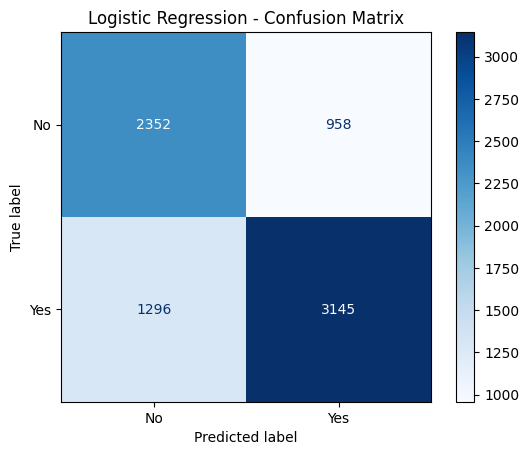

AIF360 confusion matrix for comparison:
{'TP': np.float64(3145.0), 'FP': np.float64(958.0), 'TN': np.float64(2352.0), 'FN': np.float64(1296.0)}


In [39]:
# Use confusion_matrix to plot your result here
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_pred_lr = logreg_model.predict(X_test)

# Create confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=["No", "Yes"])

# Plot it
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["No", "Yes"])
disp_lr.plot(cmap='Blues')
plt.title('Logistic Regression - Confusion Matrix')
plt.show()

# Sanity check with AIF360
print("AIF360 confusion matrix for comparison:")
print(classified_metric_lr.binary_confusion_matrix(privileged=None))

In [40]:
# As a sanity check, it is a good idea to compare these results with the ones we would get using aif360
# If they don't match, something went wrong
classified_metric_lr.binary_confusion_matrix(privileged=None)

{'TP': np.float64(3145.0),
 'FP': np.float64(958.0),
 'TN': np.float64(2352.0),
 'FN': np.float64(1296.0)}

#### Confusion Matrix - random forest:

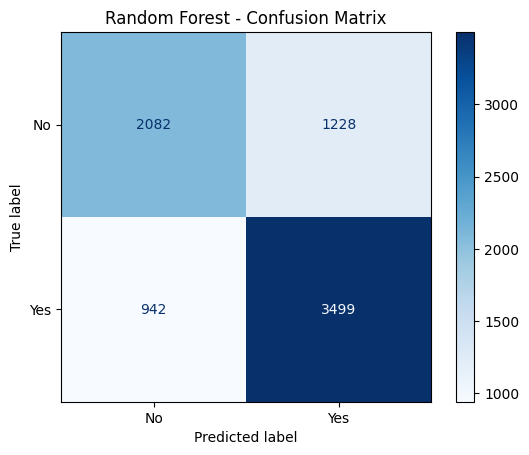

AIF360 confusion matrix for comparison:
{'TP': np.float64(3499.0), 'FP': np.float64(1228.0), 'TN': np.float64(2082.0), 'FN': np.float64(942.0)}


In [48]:
# Use confusion_matrix to plot your result here
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_pred_rf = rf_model.predict(X_test)

# Create confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=["No", "Yes"])

# Plot it
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["No", "Yes"])
disp_rf.plot(cmap='Blues')
plt.title('Random Forest - Confusion Matrix')
plt.show()

# Sanity check with AIF360
print("AIF360 confusion matrix for comparison:")
print(classified_metric_rf.binary_confusion_matrix(privileged=None))

In [42]:
classified_metric_rf.binary_confusion_matrix(privileged=None)

{'TP': np.float64(3499.0),
 'FP': np.float64(1228.0),
 'TN': np.float64(2082.0),
 'FN': np.float64(942.0)}

#### Confusion Matrix - decision tree:

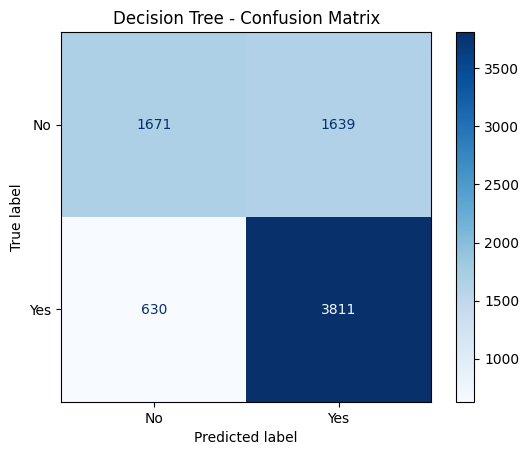

AIF360 confusion matrix for comparison:
{'TP': np.float64(3811.0), 'FP': np.float64(1639.0), 'TN': np.float64(1671.0), 'FN': np.float64(630.0)}


In [43]:
# Use confusion_matrix to plot your result here
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_pred_dt = tree_model.predict(X_test)

# Create confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=["No", "Yes"])

# Plot it
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=["No", "Yes"])
disp_dt.plot(cmap='Blues')
plt.title('Decision Tree - Confusion Matrix')
plt.show()

# Sanity check with AIF360
print("AIF360 confusion matrix for comparison:")
print(classified_metric_dt.binary_confusion_matrix(privileged=None))

In [44]:
classified_metric_dt.binary_confusion_matrix(privileged=None)

{'TP': np.float64(3811.0),
 'FP': np.float64(1639.0),
 'TN': np.float64(1671.0),
 'FN': np.float64(630.0)}

#### Confusion Matrix XGBoost:

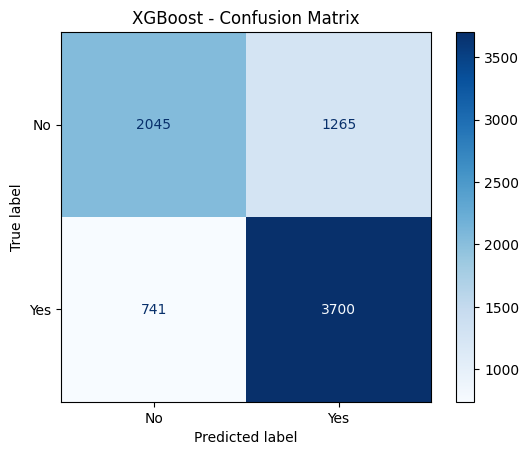

AIF360 confusion matrix for comparison:
{'TP': np.float64(3700.0), 'FP': np.float64(1265.0), 'TN': np.float64(2045.0), 'FN': np.float64(741.0)}


In [46]:
# Use confusion_matrix to plot your result here
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions (these are numeric: 0, 1)
y_pred_xgb_numeric = xgboost_model.predict(X_test)

# Convert numeric predictions back to strings to match y_test
reverse_label_map = {0: "No", 1: "Yes"}
y_pred_xgb_strings = pd.Series(y_pred_xgb_numeric.astype(int)).map(reverse_label_map)

# Create confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb_strings, labels=["No", "Yes"])

# Plot it
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=["No", "Yes"])
disp_xgb.plot(cmap='Blues')
plt.title('XGBoost - Confusion Matrix')
plt.show()

# Sanity check with AIF360
print("AIF360 confusion matrix for comparison:")
print(classified_metric_xgb.binary_confusion_matrix(privileged=None))

In [47]:
classified_metric_xgb.binary_confusion_matrix(privileged=None)

{'TP': np.float64(3700.0),
 'FP': np.float64(1265.0),
 'TN': np.float64(2045.0),
 'FN': np.float64(741.0)}

### Question 4

Based on the results obtained so far, answer the following questions, providing an explanation and trying to base your decision on multiple metrics:
- Which classifiers would you choose for deployment?
- Which classifier is the most "severe" (a.k.a. classifies more people as at risk of committing another crime within 3 years)?
- Which classifier is the most cautious (a.k.a. classifies less people as at risk of committing another crime within 3 years)?

**Your answer here**
- I would choose XGBoost for deployment because it has the best overall performance with the highest F1 score (0.787) and accuracy (0.741). This means it provides a good balance between catching actual recidivists (recall) and not falsely labeling people (precision). In a criminal justice context, having this balance is important because we want to protect public safety without unfairly denying parole to people who won't reoffend. XGBoost outperforms the other models in finding this middle ground.
- The Decision Tree is the most severe classifier, predicting recidivism for 70.3% of cases (5,450 out of 7,751 people). This makes sense given its very high recall (0.858). It's aggressive about flagging potential recidivists, which means it catches more actual offenders but also creates more false positives. This could lead to more people being unfairly denied parole.
- 

In [49]:
# Calculate severity (how many predicted "Yes")
print("Number of 'Yes' predictions (severity) by model:\n")

for model_name, y_pred in [
    ("Logistic Regression", y_pred_lr),
    ("Random Forest", y_pred_rf),
    ("Decision Tree", y_pred_dt),
    ("XGBoost", pd.Series(y_pred_xgb_numeric).map({0: "No", 1: "Yes"}))
]:
    yes_count = (y_pred == "Yes").sum()
    yes_percentage = (yes_count / len(y_pred)) * 100
    print(f"{model_name}: {yes_count} ({yes_percentage:.1f}%)")

Number of 'Yes' predictions (severity) by model:

Logistic Regression: 4103 (52.9%)
Random Forest: 4727 (61.0%)
Decision Tree: 5450 (70.3%)
XGBoost: 4965 (64.1%)


# Part 3 :  Fairness Evaluation:

Now that we have an understanding of how accurate our classifiers are across all samples, we need to measure their *fairness* across different categories. In similar problems, we are typically concerned with the classifiers being fair across different segments of protected populations (e.g. different genders or ethnicities). The original paper evaluates fairness for both gender and race, but for the purpose of this exercise we will only look at fairness across race, that is, for white and Black defendants.

### Question 5

As we have seen in class, there is not just one fairness metric, but several, as they have different ways to identify different treatments across populations. The metrics used in the paper are:

1. *Predicted Positive Rate Disparity (PPRD)*, whether the numbers of positive predictions are on par across groups.
2. *Predicted Positive Group Rate Disparity (PPGRD)*, whether the rates of positive predictions are on par across groups.
3. *False Discovery Rate Disparity (FDRD)*, whether the ratios of false positives to predicted positives are on par across groups.
4. *False Positive Rate Disparity (FPRD)*, whether the ratios of false positives to actual negatives are on par across groups.
5. *False Omission Rate Disparity (FORD)*, whether the ratios of false negatives to predicted negatives are on par across groups.
6. *False Negative Rate Disparity (FNRD)*, whether the ratios of false negatives to actual positives are on par across groups.

Before jumping into code writing, we must make sure that we have a solid understanding of how these metrics are computed from the True Positive, True Negative, False Positive, and False Negative values *for each group*. We will add the subscript *b* and *w* when appropriate to identify metrics from the group of black or white defendants, respectively. Then, we will write the equations for all fairness metrics. The first one is provided to you as an example:

| Metric    | Formula |
| :-------- | :------- |
| PPRD  |  (TPb + FPb) / (TPw + FPw)  |
| PPGRD | [(TPb + FPb) / (TPb + FPb + TNb + FNb)] / [(TPw + FPw) / (TPw + FPw + TNw + FNw)]  |
| FDRD | [FPb / (TPb + FPb)] / [FPw / (TPw + FPw)]  |
| FPRD | [FPb / (FPb + TNb)] / [FPw / (FPw + TNw)]  |
| FORD | [FNb / (FNb + TNb)] / [FNw / (FNw + TNw)]  |
| FNRD | [FNb / (FNb + TPb)] / [FNw / (TPw + FNw)]  |


## Question 6

Now that we have our formulas, let's test them by manually calculating some fairness metrics based on these two hypothetical confusion matrices:

| Confusion Matrix Group A | | | Confusion Matrix Group B |  | |
|--------------------|--|--|--------------------|--|--|
|        | Pred 1 | Pred 0 |        | Pred 1 | Pred 0 |
| **Actual 1** | 55 | 5 | **Actual 1** | 30 | 30 |
| **Actual 0** | 30 | 410 | **Actual 0** | 20 | 420 |

Helping yourself with the table from Question 5, compute the PPGDR, FPRD and FNRD for this scenario, using Group A as the reference (denominator). If we assumed that the positive class (1) represents the most desirable outcome, which group is at an advantage? Explain your answer.

PPGRD = 

FPRD =  

FNRD = 


## Question 7

Now we will move to computing a selection of fairness metrics on the 4 estimators we are testing, so that we may test if they are producing fair classifications. We will compute all the metrics, except for PPDR.

Since we will be using the `aif360` library, you will need to read its documentation to figure out which functions will give us the result we are looking for. Check the documentation on the [`ClassificationMetric` class](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.ClassificationMetric.html#), and complete the table below with the correct methods. The first one is given as an example:

| Metric    | ClassificationMetric method |
| :-------- | :------- |
| PPGRD |  `disparate_impact()` |
| FDRD |   |
| FPRD |   |
| FORD |   |
| FNRD |   |

## Question 8

We are finally ready to compute the fairness metrics on our models! Do so for all models, and add the results to `results_dict`, so that we may easily compare them later.

**Hint:** it is highly recommended to repurpose the `ClassificationMetric` objects created in Question 2.

### LogReg Model:

### Random Forest Model:

### Tree Model:

### XGBoost Model:

### Question 9

Based on the results obtained so far, answer the following questions, providing an explanation for each answer:
- Which model would you say exhibits the least amount of bias? Which one shows the most bias?
- Based on the application, which fairness metric(s) do you think should be the most important? Which one(s) could be taken less into consideration?
- Finally, based on the fairness results, which model would you pick for this application? Is your pick different from the one based on performance metrics alone?

# Part 4: Interpretability Evaluation:

Finally, we will evaluate the *interpretability* of our models. It is important to be able to explain how the model uses each feature to make its predictions and *why* a model has given a particular response for an individual - especially important when, like in this case, people's lives are being affected.

### Inherently Interpretable Models

Some models are known to be *inherently interpretable*, meaning we can decifer the model behavior by looking at its parameters. These models are also called "white-box" models. Logistic regression models and decision trees - in some cases - fall in this category.

### Question 10

Run the cells below and look at the weights of the logistic regression model. For simplicity, the cells below show the 10 most positive and 10 most negative coefficients. What features bring the prediction more toward the positive class? What other features push the prediction toward the negative class? Do you see any coefficients that may be unfairly influencing the decision?

In [ ]:
feature_names = np.array(logreg_model.named_steps['columntransformer'].get_feature_names_out())
coeffs = logreg_model.named_steps["logisticregression"].coef_.flatten()
coeff_df = pd.DataFrame(coeffs, index=feature_names, columns=["Coefficient"])
coeff_df_sorted = coeff_df.sort_values(by="Coefficient", ascending=False)

In [ ]:
coeff_df_sorted.head(10)

In [ ]:
coeff_df_sorted.tail(10)

### Question 11

Now, let's look at a particular sample and try to explain its prediction. We have picked this sample because its feature values make it a hard case, one very close to the threshold between positive and negative class:

In [ ]:
hard_sample = X_test[5:6]

If you look at the ground truth for this sample you will see that this person has, in fact, committed a new crime within 3 years from release. But what is the prediction of the logistic regression model? Find the answer below:

In [ ]:
logreg_model.predict(hard_sample)

In [ ]:
# The label for this sample is, in fact, 'Yes'
y_test[5]

Take a closer look at the feature values for this sample. What seems to have contributed the most to the final prediction? What feature pushed the most in the opposite direction?

### Question 12
We said that decision trees are also inherently interpretable - *potentially*. That is because, in theory, it is possible to look at the tree structure and to follow the path along the tree to see how each node influenced the decision. But this is only possible if the tree has a reasonably small size.

Run the cell below and see if you can tell what are the most influencial features in the decision tree model.

In [ ]:
from sklearn import tree

tree.plot_tree(tree_model["dt"],fontsize=10)
plt.figure(figsize=(10,6))
plt.show()

If the method above was not satisfactory, you can try visualizing all the rules of the decision tree as text. Is this any better?

In [ ]:
from sklearn.tree import export_text
tree_rules = export_text(tree_model.named_steps['dt'], feature_names=list(tree_model.named_steps['ct'].get_feature_names_out()))
print(tree_rules)

When it is not possible to interpret a decision tree because of its complex structure, we can still extract other information from it that will help us understand the features' importance in the decision. The code in the cell below extracts the feature importances from the model (line 3), then uses this information to create a bar plot of features sorted by importance. The feature importance extracted this way is based on [Gini Importance](https://www.codecademy.com/article/fe-feature-importance-final) (as it is done in the original paper), which reflects how the features were picked when building the decision tree.

In [ ]:
import seaborn as sns

feature_importances = tree_model.named_steps["dt"].feature_importances_

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = tree_model.named_steps['ct'].get_feature_names_out()[sorted_indices[0:20]] # Output limited to top 20 features
sorted_importances = feature_importances[sorted_indices[0:20]]

# # Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(11.7,30)})
sns.barplot(x=sorted_importances, y=sorted_feature_names)

Comment on the features importance of the tree model, compared to those seen in the logistic regression model, as well as the original paper results. Also, **what is a big limitation of using feature importance, compared to observing the coefficient of the logistic regression model?**

### Question 13

As before, we are interested in evaluating how the model classifies a particular sample. Let's start looking at the classification for our `hard_sample`. Is it correct?

In [ ]:
tree_model.predict(hard_sample)

We would like to be able to tell what sequence of rules has led to this final decision, but, for a tree this large, this can be difficult, unless we want to manually sift through the list of rules or write some elaborate custom code. In the next sections, we will see an alternative method (SHAP) to achieve this result.

### Question 11: Evaluation of Non-inherently Interpretable Models Using a Surrogate Model

Models that are not inherently interpretable ("black box" models) can still be examined to understand how they used the available features to make their predictions. In fact, there are many strategies to do this. The first one we are going to see is through use of a **surrogate model.** In this case, we train another model - an inherently interpretable one, such as a logistic regressor - on the *predictions* of the black box model, and then we try to interpret *its parameters*. Let's complete the code below to do that on the 3 non-inherently interpretable models included in this exercise: Random Forest and XGBoost.

#### Surrogate for Random Forest Model

In [ ]:
# Step 1: create logistic regressor object.
# For simplicity, we will use the already existing "NIJ_logreg.joblib" and re-train it, instead of creating
# a new one. The reason for this decision is that NIJ_logreg.joblib already knows how to handle the features
# of this dataset, while a new one will need to be designed to do so.

surrogate_model_rf = joblib.load("models_for_A3/NIJ_logreg.joblib")

# Step 2: train model on random forest predictions on the training set
y_pred_rf_train = rf_model.predict(X_train)
surrogate_model_rf.fit(X_train, y_pred_rf_train)

# Step 3: visualize weights of surrogate model, as we did for the original logistic regression model
eli5.explain_weights(surrogate_model_rf[-1], feature_names=surrogate_model_rf[:-1].get_feature_names_out())

Now that we have the weights of the surrogate model, what can we say about how the Random Forest model makes its predictions? What features seem more important? Are they similar to what we have seen for the other models so far?

**Note:** using a surrogate model is not always a very good strategy, because the simpler "white box" model is often unable to replicate the behavior of the most complex "black box" model. We can get a sense of how close the surrogate is approximating the original model by looking at the R<sup>2</sup> score. In the paper, they do so when trying to create a surrogate for XGBoost, and they explain: 

*The R<sup>2</sup> value between the XGBoost predictions and the surrogate model predictions on the test set is 0.38. The surrogate model only explains 38% of the variance in the XGBoost model’s predictions*

Test this for the random forest surrogate model. How much variance is it able to capture?

**Hints:**
- Think carefully about what constitues the array of predictions and the array of ground truths in this case
- You may remember that R<sup>2</sup> is, in fact, a metric for regression, not for classification! How can we use R<sup>2</sup> in this case? There are various ways to approximate R<sup>2</sup> for classification, as explained [here](https://datascience.oneoffcoder.com/psuedo-r-squared-logistic-regression.html). We will use the simplest one and use **count R<sup>2</sup>**, which is simply the accuracy of the surrogate classifier

In [ ]:
from sklearn.metrics import r2_score
surrogate_pred = surrogate_model_rf.predict(X_train)

# compute count R2 

Now, repeat the analysis through surrogate model for XGBoost. Comment on the results, including considerations on the following:
- What seem to be the most important features?
- How do the sets of most important features compare across models (do not forget logistic regression and decision tree in this comparison)?
- How good are the surrogate models, in terms of capturing the variance of the original model? Are they reliable?
- ...more thoughts of your choice...

#### Surrogate for XGBoost Model

### Question 12: Evaluation of Non-inherently Interpretable Models Using Permutation Feature Importance

Another method used to interpret black box models is using feature permutation, which means changing the value of a feature and observing changes in the model's prediction error. More important features, when changed, will result in more frequent mistakes.

Luckily for us, Permutation Feature Importance already exists as a function in Scikit-Learn! All you have to do it is looking at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) to learn how it works, and apply it to the 3 non-inherently interpretable models of this exercise. Let's start with Random Forest.

#### Random Forest Model:

In [ ]:
# Use permutation_importance on the random forest model, and save the result in a variable called "out"
out = permutation_importance(rf_model, X_test, y_test, random_state=0)

After you are done, you can run the cell below to visualize the top 5 most important features in a bar chart. If you like, you can change the number of features shown or try other visualization methods.

In [ ]:
result = pd.DataFrame({"Name": X_test.columns, "Importance": out["importances_mean"], "STD": out["importances_std"]})
result = result.sort_values(by=['Importance'], ascending=False)

sns.set(rc={'figure.figsize':(11.7,7)})
sns.barplot(data=result[:5], y="Name", x="Importance")

Now, use Permutation Feature Importance on XGBoost.

**Hint:** these are more complex models; if you find that this task is taking too long, you may consider reducing the number of permutations using the parameter `n_repeats`. Be aware that this produces more variable results.

#### XGBoost Model:

In [ ]:
# Your solution here

Now that you have completed your analysis of feature importance using permutation, comment on the results. How do the sets of most important features compare with each other? Are this results similar to what you observed using the surrogate model?

### Question 13: Evaluation of Non-inherently Interpretable Models Using SHAP

The last method we are going to use to interpret the impact of each feature in our model is called SHAP, which stands for SHapley Additive exPlanations. How SHAP works is beyond the scope of this course, but if you are curious you can read the [original paper](https://arxiv.org/pdf/1705.07874.pdf) by Lundberg and Lee and check out [Lundberg's GitHub repo](https://github.com/shap/shap), which provides details on the implementation and examples.

You will need to install SHAP to be able to use it:
```
pip install shap
or
conda install -c conda-forge shap
```

Then, import it:

In [ ]:
import shap # may require to downgrade numpy to version = 1.23
shap.initjs()

SHAP needs the model (we will start with Random Forest) and samples to use to explain the predictions. For this, we will need to give it transformed samples (scaled and imputed, as required by the model) from  `X_train` or `X_test`.

In [ ]:
X_train_enc = pd.DataFrame(
    data=rf_model.named_steps['ct'].transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

X_test_enc = pd.DataFrame(
    data=rf_model.named_steps['ct'].transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

ind = np.random.choice(len(X_test_enc) - 1, 1000)  
# This line just gives 1000 random indexes from the training set
# We do this because getting SHAP values for all samples would be a bit too long, but you 
# are free to try it out!

ind = np.append(ind, 5) # adding the hard sample - we'll need this later

The following lines are all that's needed to explain the model's predictions for a set of samples:

In [ ]:
rf_explainer = shap.TreeExplainer(rf_model[-1])  # creating SHAP Explainer based on the model

rf_shap_values = rf_explainer.shap_values(X_test_enc.iloc[ind])  # explaining predictions for 1000 random samples

This gives us the SHAP values for each sample and each feature (values for the positive class):

In [ ]:
rf_shap_values[:,:,1]

This is hardly interpretable, though. It is better to get the average values for each feature, which returns something similar to feature importance:

In [ ]:
values = np.abs(rf_shap_values[:,:,1]).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]

The SHAP library also has a lot of ways to visualize and interpret the SHAP values - try it out!

In [ ]:
shap_figure = shap.summary_plot(rf_shap_values[:, :, 1], X_test_enc.iloc[ind], plot_size=[12,6])

Given the new information obtained using the SHAP library on the Random Forest model, explain the results (you will need to refer to the SHAP documentation - or ask us for help interpreting the plots) and comment on the difference between these results and those obtained using the other methods.



Next, **repeat this analysis for XGBoost.**

In [ ]:
# Your solution here

### Question 14: Explaining individual predictions using SHAP

Another powerful feature of SHAP is that it allows us to explain the impact of each feature on individual predictions. For example, we will be able to explain how the prediction for our hard sample was generated. Let's start by looking at the prediction for this sample given by the random forest model. **Is it correct?**

In [ ]:
rf_model.predict(hard_sample)

Let's look at the **force plot** for this particular prediction, by running the cell below:

In [ ]:
shap.force_plot(
    rf_explainer.expected_value[1],
    rf_shap_values[:,:,1][-1],
    X_test_enc.iloc[ind[-1]],
    matplotlib=True,
)

**Interpret the plot results,**, including the following:
- What contributed the most to the prediction?
- What countered the prediction the most?
- Can we tell, by looking at the plot, that this was a difficult prediction?

Finally, **repeat the analysis and comment on the results of the individual predictions made on the hard sample by XGBoost and Decision Tree** (since we were not able to do the latter earlier).

In [ ]:
# Your answer here


# Part 5: Final Evaluation:

### Question 15

Using **all the results collected so far** on accuracy, fairness and transparency of the 5 model, write your recommendation about what model, in your opinion, should be employed for this application (300 words max).

# Final thoughts

1) If you have completed this assignment in a group, please write a detailed description of how you divided the work and how you helped each other completing it:

2) Have you used ChatGPT or a similar Large Language Model (LLM) to complete this homework? Please describe how you used the tool. We will never deduct points for using LLMs for completing homework assignments, but this helps us understand how you are using the tool and advise you in case we believe you are using it incorrectly.

3) Have you struggled with some parts (or all) of this homework? Do you have pending questions you would like to ask? Write them down here!